In [180]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import PIL
from tensorflow import keras
import tensorflow as tf
from keras import layers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

## 1) The Dataset

#### Assuming you have a classification problem, is it binary, multi-class or multi-label?

I have a multi-class classification problem.

In [181]:
path = 'data/datasets-resized'

#Loading images from folder
import glob
import cv2
from skimage import io
from skimage.transform import resize

types = ['*.jpg', '*.jpeg']

#Creating list images and labels
images = []
labels = []

# Iterate the folder with glob
for fpath in glob.glob(path + '/*.jpg'): 
    # Read the image with OpenCV    
    im = cv2.imread(fpath) 
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # Assigning labels to images
    if 'glass' in fpath:
        label = 0 
    elif 'metal' in fpath:
        label = 1
    elif 'paper' in fpath:
        label = 2 
    elif 'plastic' in fpath:
        label = 3
    elif 'cardboard' in fpath:
        label = 4
        
    im_rgb = cv2.resize(im_rgb, (64, 64))
    #Put image array to X    
    #Put label to y    
    images.append(im_rgb)
    labels.append(label)
    
#Convert X and y to numpy array
images = np.array(images)
labels = np.array(labels)

#### Train/Test/validation sizes- Image size?

In [182]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images,
                                                    labels,
                                                    test_size=1/10,
                                                    random_state=0)

# Convert labels to one-hot encoded matrix
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

print(X_train.shape, X_test.shape)

(2152, 64, 64, 3) (240, 64, 64, 3)


In [183]:
# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=1/9,
                                                  random_state=0)
                                                  
print(X_train.shape, X_val.shape, X_test.shape)

(1912, 64, 64, 3) (240, 64, 64, 3) (240, 64, 64, 3)


In [184]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(1912, 64, 64, 3) (240, 64, 64, 3) (240, 64, 64, 3) (1912, 5) (240, 5) (240, 5)


#### Show a few examples per class

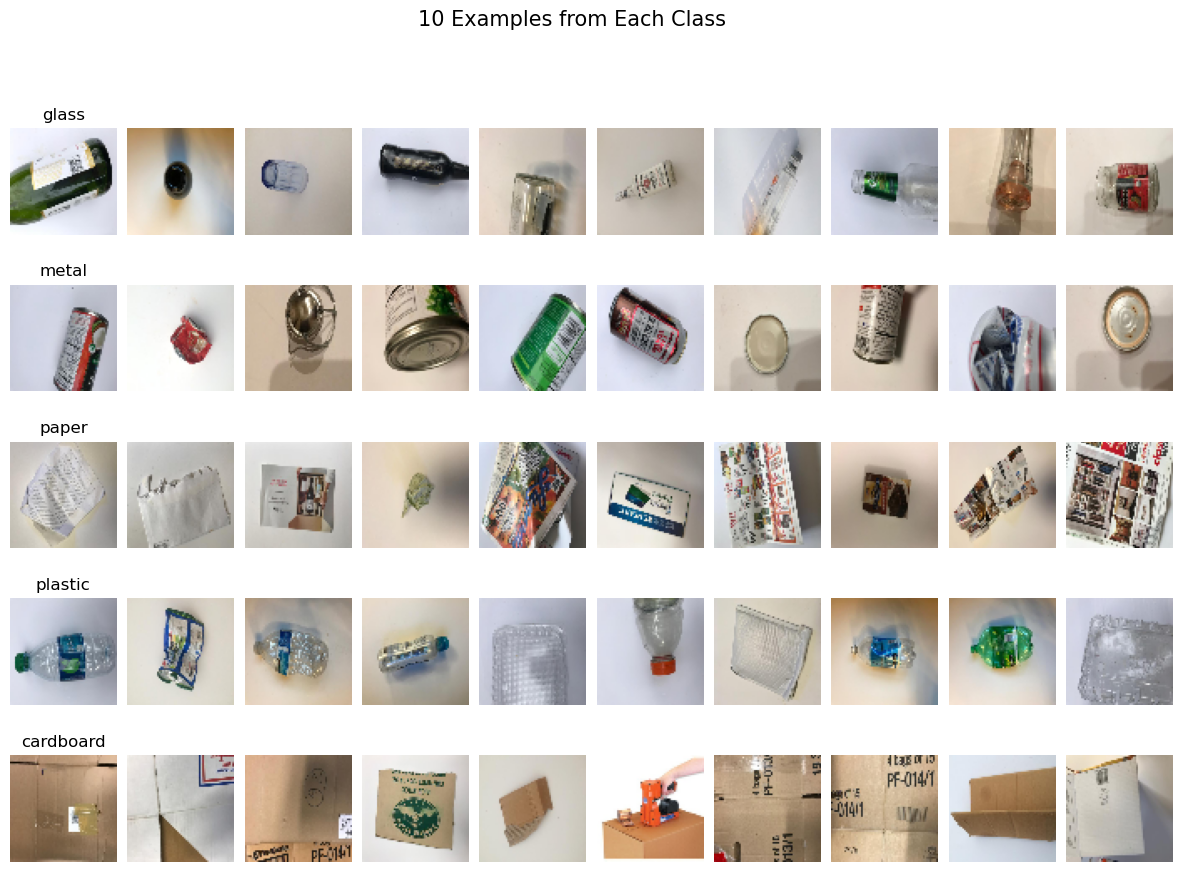

In [185]:
#Define class names
class_names = ['glass', 'metal', 'paper', 'plastic', 'cardboard']

#Set up the figure with 5 rows and 10 columns of subplots
fig, axes = plt.subplots(5, 10, figsize=(15, 10))

#Set the title of the figure
fig.suptitle('10 Examples from Each Class', fontsize=15)

#Iterate over the 5 classes
for i in range(5):
    #Get indices of images with current class label
    class_indices = np.where(labels == i)[0]
    #Randomly select 10 images from the current class
    sample_indices = np.random.choice(class_indices, size=10, replace=False)
    #Display the 10 images in a row
    for j, idx in enumerate(sample_indices):
        axes[i, j].imshow(images[idx])
        axes[i, j].axis('off')
        #Add the class name as a title to the first subplot in each row
        if j == 0:
            axes[i, j].set_title(class_names[i])
            
#Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

#### How many classes?

I have 5 different classes: glass, metal, paper, plastic and cardboard.

#### How many images per class?

In [186]:
for class_name in class_names:
    images = [f for f in os.listdir(path) if f.startswith(class_name) and os.path.isfile(os.path.join(path, f))]
    print(f"Class: {class_name}, Number of Images: {len(images)}")

Class: glass, Number of Images: 501
Class: metal, Number of Images: 409
Class: paper, Number of Images: 594
Class: plastic, Number of Images: 480
Class: cardboard, Number of Images: 408


#### How are the images labeled?

The filenames of the images carry the label information along with a unique identifier. For instance, an image depicting a cardboard material may have a filename such as "cardboard123.jpg", where "cardboard" represents the label and "123" is a unique identifier assigned to the image.

#### Dataset source(s)?

- https://github.com/garythung/trashnet
- imsitu dataset

## 2) Baselines

#### Random guess accuracy?

I have 5 classes so my random guess accuracy is 20%.

#### Human-Level Performance accuracy?

https://forms.office.com/e/3P7z31jPHu

#### Multilayer Perceptron accuracy?

In [187]:
#score = model.evaluate(X_test, y_test, verbose=0)
# print("Test accuracy:", score[1])


## 3) Preprocessing

#### Explain all the preprocessing steps you did.

## 4) CNN Architecure

In [202]:

model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(5, activation='softmax')) 


## 5) CNN training

#### Loss function/Optimizer (with its hyper-parameters)/Metrics

In [205]:
from keras.optimizers import Adam

#Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Training

In [204]:
early_stopping = EarlyStopping(monitor='val_loss', patience= 5, mode='auto')
history = model.fit(X_train, y_train, batch_size=32, epochs=30, callbacks=early_stopping, validation_data=(X_test, y_test))

Epoch 1/30
60/60 [==============================] - 4s 55ms/step - loss: 3.3159 - accuracy: 0.3468 - val_loss: 1.3136 - val_accuracy: 0.3833
Epoch 2/30
60/60 [==============================] - 2s 40ms/step - loss: 1.1886 - accuracy: 0.5178 - val_loss: 1.1722 - val_accuracy: 0.4708
Epoch 3/30
60/60 [==============================] - 2s 39ms/step - loss: 1.0691 - accuracy: 0.5894 - val_loss: 1.1824 - val_accuracy: 0.4875
Epoch 4/30
60/60 [==============================] - 2s 41ms/step - loss: 0.8975 - accuracy: 0.6459 - val_loss: 1.1462 - val_accuracy: 0.5500
Epoch 5/30
60/60 [==============================] - 2s 39ms/step - loss: 0.7432 - accuracy: 0.7233 - val_loss: 1.1602 - val_accuracy: 0.5708
Epoch 6/30
60/60 [==============================] - 3s 42ms/step - loss: 0.6211 - accuracy: 0.7683 - val_loss: 1.2798 - val_accuracy: 0.5667
Epoch 7/30
60/60 [==============================] - 2s 40ms/step - loss: 0.5635 - accuracy: 0.8002 - val_loss: 1.1463 - val_accuracy: 0.5750
Epoch 8/30
60

In [206]:
#Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(X_test, y_test)

#Print the validation accuracy as a percentage with two decimal places
print("Validation accuracy: {:.2%}".format(val_accuracy))

8/8 [==============================] - 1s 16ms/step - loss: 1.4935 - accuracy: 0.6542
Validation accuracy: 65.42%


#### Learning curves

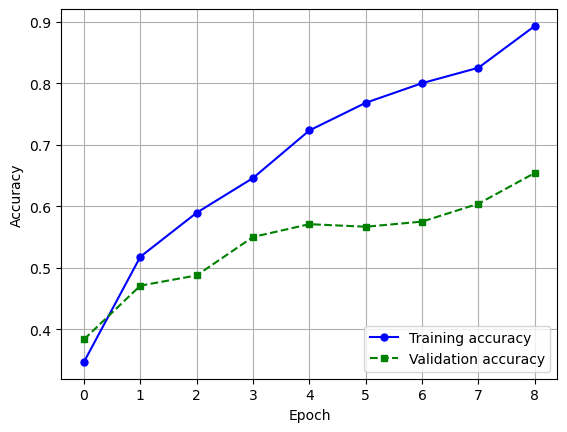

In [215]:
#Extract the training and validation accuracies for each epoch from the history object
val_acc = history.history['val_accuracy']
train_acc = history.history['accuracy']

#Set the number of epochs
num_epochs = len(val_acc)

#Plot the training and validation accuracies
plt.plot(range(num_epochs), train_acc, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.plot(range(num_epochs), val_acc, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

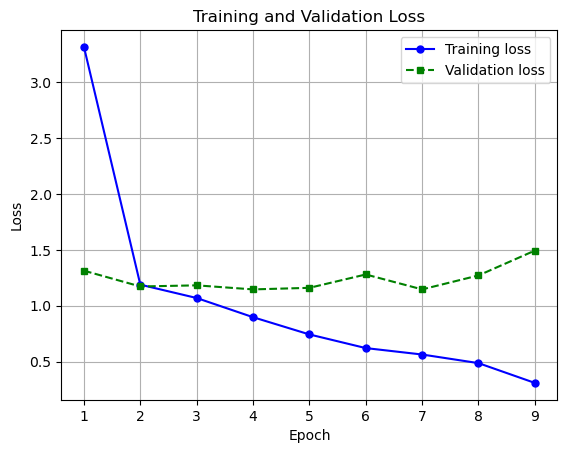

In [214]:
#Extract the training and validation losses for each epoch from the history object
val_loss = history.history['val_loss']
train_loss = history.history['loss']

#Plot the training and validation losses
plt.plot(range(1, len(train_loss) + 1), train_loss, color='blue', marker='o', markersize=5, label='Training loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, color='green', linestyle='--', marker='s', markersize=5, label='Validation loss')
plt.grid()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## 6) Model performance

#### Metrics plots

8/8 [==============================] - 0s 38ms/step


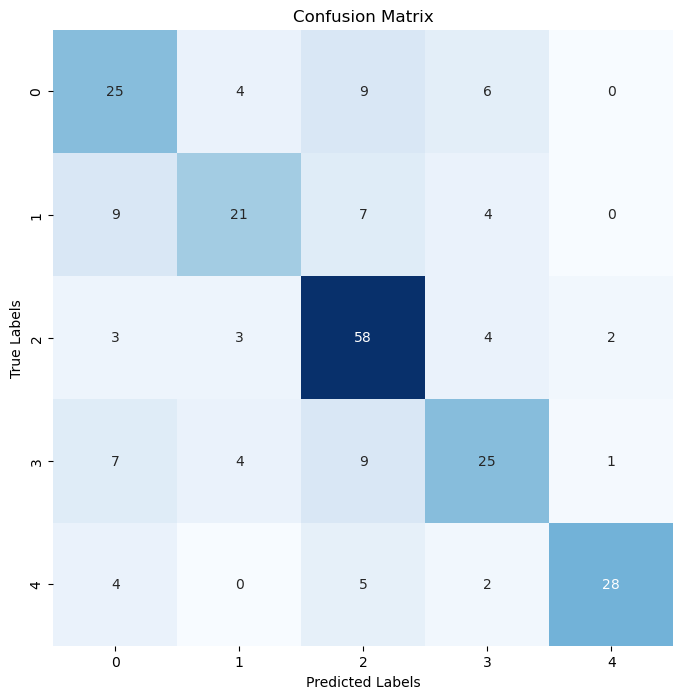

In [209]:
# Get the true labels and predicted labels
y_true = y_test
y_pred = model.predict(X_test)

# Convert the predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix using matplotlib
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [210]:
# Convert the matrix to a Pandas DataFrame
cm_df = pd.DataFrame(cm)


In [211]:
# Compute accuracy score
accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Print the accuracy score
print('Accuracy:', np.round(accuracy, 4))

# Compute precision score
precision = precision_score(y_true_labels, y_pred_labels, average='macro')

# Print the precision score
print('Precision:', np.round(precision, 4))

# Compute recall score
recall = recall_score(y_true_labels, y_pred_labels, average='macro')

# Print the recall score
print('Recall:', np.round(recall, 4))

# Compute F1 score
f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

# Print the F1 score
print('F1 Score:', np.round(f1, 4))

Accuracy: 0.6542
Precision: 0.6698
Recall: 0.6341
F1 Score: 0.6455


In [213]:
# Baseline comparison
pd.DataFrame({'Random guess (%)': [10],
              'MLP(%)': [95],
              'CNN(%)':[np.round(acc, 3)*100],
              'HLP(%)':[99.9]})

NameError: name 'acc' is not defined

## 7) Error analysis

#### Top error interpretation